In [88]:
from IPython.display import Image
import pandas as pd
import numpy as np
from pgmpy.estimators import BdeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BayesianEstimator
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage  # for hierarchical clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score

### Q1 (15 points) 

#### This question is to be solved by hand.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

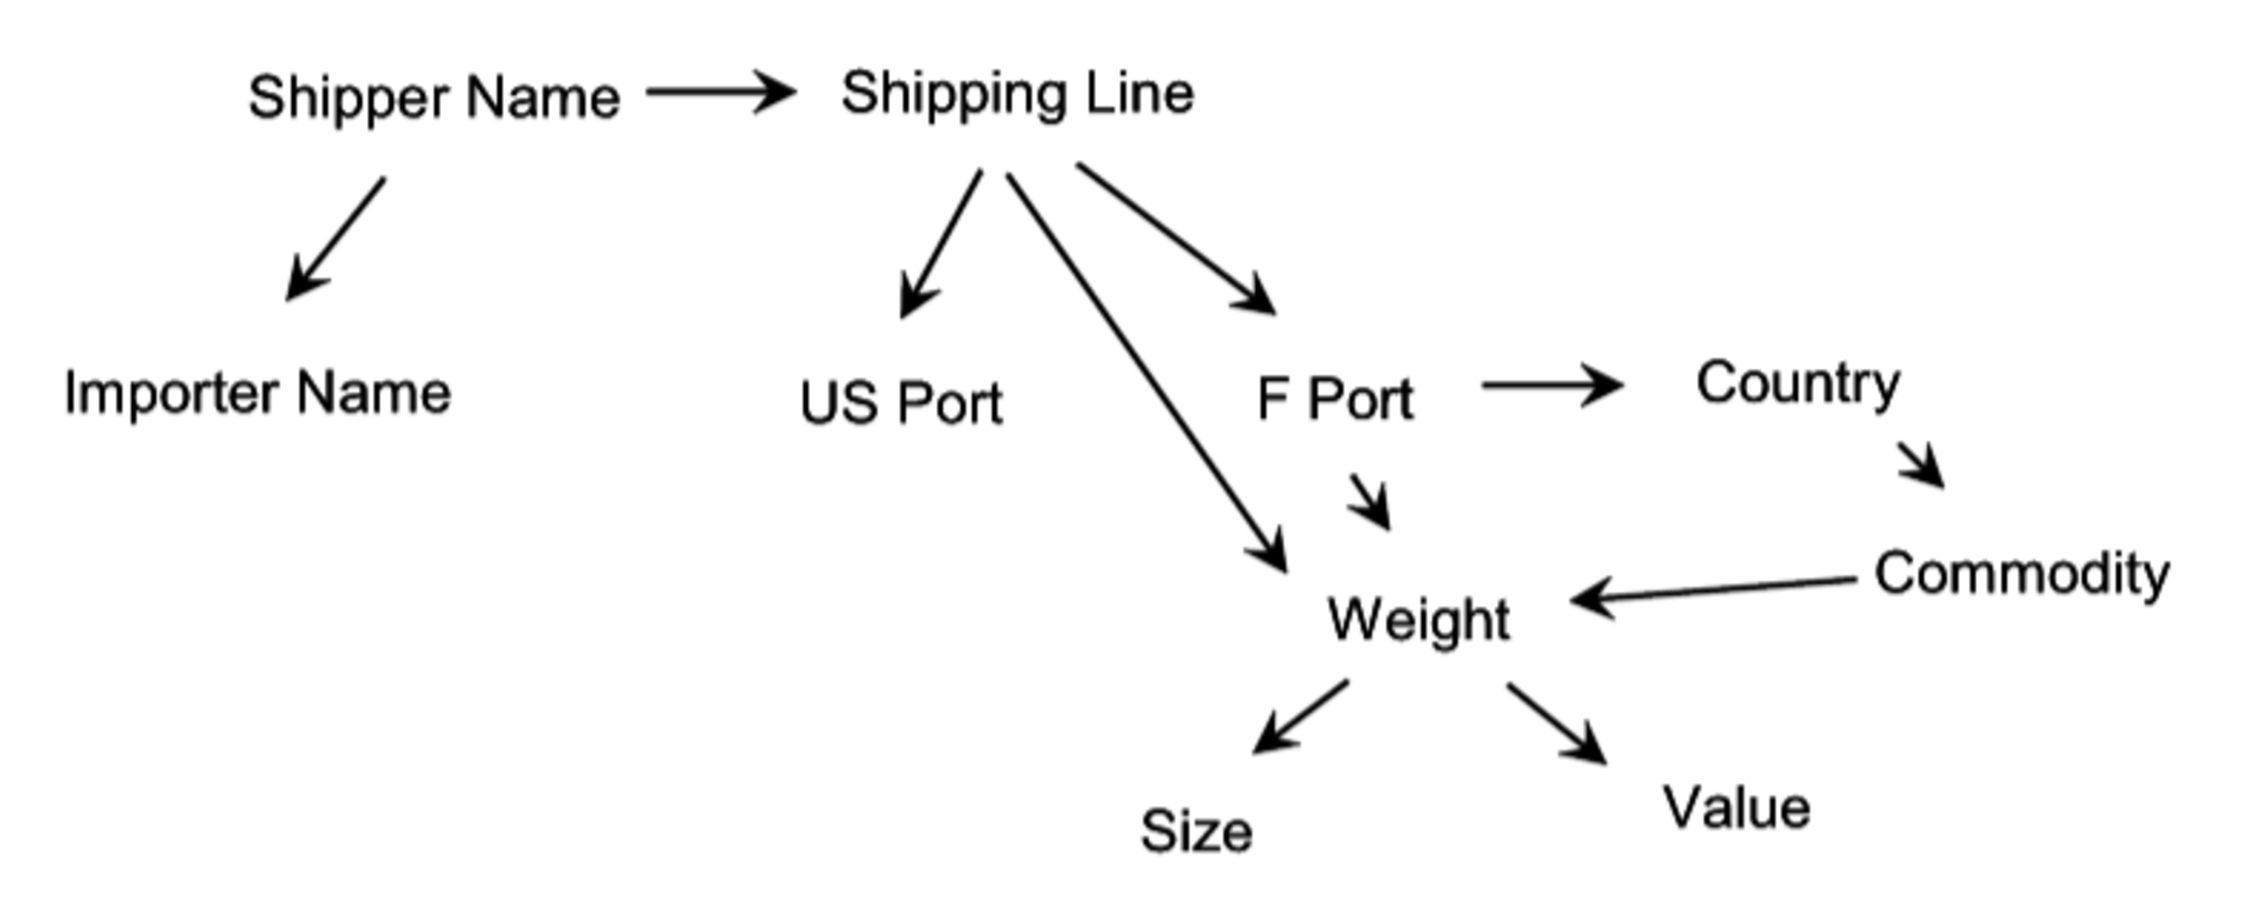

In [4]:
Image('HW3Q1.png')

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):

CI (Shipper Name, Value | F Port)? Dependent

CI (Shipper Name, Value | Shipping Line)? Independent

CI (Foreign Port, Commodity | Country)? Independent

CI (Foreign Port, Commodity | County, Weight)? Dependent

2) Now consider a smaller dataset with only four discrete attributes (Shipping Line, US Port, Foreign Port, Weight), and the following conditional probability distributions:

Shipping Line: CSCO (70%), ASCO (30%)

Foreign Port | Shipping Line = CSCO: Yokohama (40%), Vancouver (60%)

Foreign Port | Shipping Line = ASCO: Vancouver (100%)

US Port | Shipping Line = ASCO: Seattle (100%)

US Port | Shipping Line = CSCO: Seattle (80%), Los Angeles (20%)

Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Light (30%), Medium (50%), Heavy (20%)

Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Light (10%), Medium (30%), Heavy (60%)

Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Light (15%), Medium (70%), Heavy (15%)

Which of the following packages is most anomalous?

a) A heavy package shipped from Vancouver to Seattle by ASCO

b) A heavy package shipped from Vancouver to Seattle by CSCO

c) A heavy package shipped from Yokohama to Los Angeles by CSCO

To answer this question, compute the likelihood of each package given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

(Your answers here, including all calculations)

a) A heavy package shipped from Vancouver to Seattle by ASCO:
30% * 100% * 100% * 15% = 4.5%

b) A heavy package shipped from Vancouver to Seattle by CSCO:
70% * 60% * 80% * 20% = 6.72%

c) A heavy package shipped from Yokohama to Los Angeles by CSCO:
70% * 40% * 20% * 60% = 3.36%

The answer is C.

### Q2. Bayesian Network Learning (35 points)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [5]:
from sklearn.model_selection import train_test_split
data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

,A,B,C,D,E,F
0,1,0,0,0,1,1
1,0,0,0,1,0,1
2,1,1,0,1,1,1
3,1,0,0,1,1,1
4,2,0,1,0,1,1


a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10 points)

b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)

c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)   

In [6]:
# your answers here
hc = HillClimbSearch(train, scoring_method=BicScore(train))
best_model = hc.estimate()
print(best_model.edges())


[('E', 'A'), ('B', 'A'), ('D', 'A')]


### b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)


In [7]:
model = BayesianModel([('E', 'A'), ('B', 'A'), ('D', 'A')])
est = BayesianEstimator(model, train)

print(est.estimate_cpd('A', prior_type='BDeu', equivalent_sample_size=10))
print()
print(est.estimate_cpd('A', prior_type='K2'))

+------+-----------------------+------------------------+-----------------------+------------------------+----------------------+------------------------+-----------------------+------------------------+
| B    | B(0)                  | B(0)                   | B(0)                  | B(0)                   | B(1)                 | B(1)                   | B(1)                  | B(1)                   |
+------+-----------------------+------------------------+-----------------------+------------------------+----------------------+------------------------+-----------------------+------------------------+
| D    | D(0)                  | D(0)                   | D(1)                  | D(1)                   | D(0)                 | D(0)                   | D(1)                  | D(1)                   |
+------+-----------------------+------------------------+-----------------------+------------------------+----------------------+------------------------+-----------------------+------

In [8]:
model.fit(train, estimator=BayesianEstimator, prior_type='K2')
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of E:
+------+--------+
| E(0) | 0.5015 |
+------+--------+
| E(1) | 0.4985 |
+------+--------+
CPD of A:
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| B    | B(0)                 | B(0)                  | B(0)                 | B(0)                 | B(1)                  | B(1)                 | B(1)                  | B(1)                 |
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| D    | D(0)                 | D(0)                  | D(1)                 | D(1)                 | D(0)                  | D(0)                 | D(1)                  | D(1)                 |
+------+----------------------+-----------------------+----------------------+----------------------+-----

### c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)

In [9]:
test_1 = test[['B', 'D', 'E']]

In [10]:
test_predict = model.predict(test_1)

In [11]:
test_predict.head(10)

,A
3644,0
9184,1
520,1
5685,0
2401,1
6510,0
9853,1
7185,1
7444,1
49,0


In [12]:
test.head(10)

,A,B,C,D,E,F
3644,1,0,1,1,1,0
9184,2,1,0,1,1,1
520,1,1,0,1,1,0
5685,0,0,0,1,0,0
2401,1,0,0,0,1,0
6510,0,0,1,1,0,0
9853,1,0,1,0,1,1
7185,2,0,0,0,1,1
7444,1,1,1,1,1,1
49,0,0,1,1,1,0


In [13]:
print("Out of sample:",(test.loc[:,'A']==test_predict['A']).mean())

Out of sample: 0.5645


### The out of sample accuracy is 0.5645.

### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50 points)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

c) Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)  

d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)


In [14]:
data3=pd.read_csv("HW3Q3_1.csv")
data3.head(10)

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.019830,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.037037,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.035377,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.028000,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.029412,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000
5,ASSAULT: AGGRAVATED:KNIFE/CUTTING INSTR,P1V,0.154824,0.142857,0.137622,0.150337,0.134630,0.139117,0.140613,0.048616,...,0.031414,0.018699,0.008227,0.032909,0.001496,0.008975,0.000748,0.002992,0.002244,0.009723
6,ASSAULT: PRO EMP HANDS NO/MIN INJURY,P2,0.030686,0.146209,0.185921,0.240072,0.180505,0.166065,0.050542,0.005415,...,0.048736,0.032491,0.012635,0.023466,0.000000,0.010830,0.000000,0.005415,0.000000,0.007220
7,ASSAULT: SIMPLE,P2,0.133993,0.146027,0.150038,0.149014,0.146710,0.144064,0.130153,0.024068,...,0.030639,0.030810,0.009900,0.032175,0.003670,0.011180,0.001622,0.008449,0.004865,0.008620
8,BATTERY: AGG PO HANDS NO/MIN INJURY,P2,0.153061,0.119048,0.127551,0.132653,0.151361,0.164966,0.151361,0.059524,...,0.032313,0.034014,0.008503,0.028912,0.000000,0.008503,0.001701,0.008503,0.008503,0.008503
9,BATTERY: AGG: HANDS/FIST/FEET NO/MINOR INJURY,P2,0.114504,0.137405,0.190840,0.122137,0.137405,0.152672,0.145038,0.068702,...,0.007634,0.053435,0.007634,0.030534,0.000000,0.015267,0.000000,0.022901,0.000000,0.022901


In [15]:
data4=pd.read_csv("HW3Q3_2.csv")
data4.head()

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330
3,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859
4,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280


In [16]:
# your answers here

### a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

In [17]:
hours = data3.iloc[:,9:33]

In [18]:
hours.head()

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.073654,0.079320,0.076487,0.087819,0.082153,0.073654,0.039660,0.033994,0.014164,0.016997,...,0.019830,0.019830,0.025496,0.022663,0.022663,0.053824,0.033994,0.033994,0.042493,0.062323
1,0.055556,0.070370,0.033333,0.014815,0.025926,0.003704,0.007407,0.014815,0.018519,0.029630,...,0.055556,0.077778,0.048148,0.059259,0.044444,0.044444,0.077778,0.044444,0.074074,0.044444
2,0.040630,0.039580,0.033275,0.036778,0.018564,0.014011,0.012609,0.021366,0.025569,0.034676,...,0.055342,0.052189,0.059895,0.056392,0.062347,0.051839,0.053240,0.066550,0.055692,0.056042
3,0.034000,0.026000,0.018000,0.009000,0.010000,0.015000,0.020000,0.017000,0.033000,0.036000,...,0.045000,0.058000,0.073000,0.078000,0.068000,0.066000,0.059000,0.038000,0.051000,0.041000
4,0.009804,0.009804,0.029412,0.009804,0.009804,0.019608,0.039216,0.019608,0.000000,0.029412,...,0.029412,0.009804,0.107843,0.117647,0.058824,0.068627,0.078431,0.068627,0.049020,0.088235


In [19]:
km = KMeans(random_state=234,n_clusters=3)
res=km.fit(hours)
res

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=234, tol=0.0001, verbose=0)

In [20]:
print('Cluster assignments:',res.labels_)
print('\nCluster centers:\n',res.cluster_centers_)
print('\nSum of squared errors:',res.inertia_)


Cluster assignments: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 2 1 1 1 1 1 1 0 0 2 0 2 0 0 0 0 0 1 2 2 2 2 0 2 2 0 2 2 2 2 2 2 1 0 0
 1 1 0 2 2 1 1 2 1 1 0 0 2 1 2 1 0 0 2 1 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1
 0 0 0 1 0 2 0 0]

Cluster centers:
 [[0.05364158 0.04182416 0.03691183 0.03104211 0.02510576 0.01886402
  0.01946212 0.02434162 0.02766839 0.0335171  0.03680552 0.03720506
  0.04254665 0.03994431 0.04208987 0.0473956  0.05170137 0.05425891
  0.05757893 0.05599685 0.0575726  0.05411778 0.05837336 0.0520345 ]
 [0.0424857  0.0124839  0.01063242 0.00917263 0.00935287 0.00782255
  0.01345328 0.02374573 0.05099082 0.09235549 0.07911561 0.06020408
  0.08877015 0.06328364 0.06309555 0.06824587 0.06216217 0.05215833
  0.04915732 0.04164785 0.03414496 0.02476704 0.02192139 0.01883064]
 [0.02578926 0.01492578 0.01124032 0.00610476 0.00276913 0.00135912
  0.00394105 0.00860188 0.01212724 0.02407099 0.05418393 0.07890851
  0.0586388  0.05664272 0.05754662 

In [21]:
df = pd.DataFrame(res.cluster_centers_)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.053642,0.041824,0.036912,0.031042,0.025106,0.018864,0.019462,0.024342,0.027668,0.033517,...,0.042090,0.047396,0.051701,0.054259,0.057579,0.055997,0.057573,0.054118,0.058373,0.052035
1,0.042486,0.012484,0.010632,0.009173,0.009353,0.007823,0.013453,0.023746,0.050991,0.092355,...,0.063096,0.068246,0.062162,0.052158,0.049157,0.041648,0.034145,0.024767,0.021921,0.018831
2,0.025789,0.014926,0.011240,0.006105,0.002769,0.001359,0.003941,0.008602,0.012127,0.024071,...,0.057547,0.044079,0.039107,0.043985,0.073090,0.106785,0.091043,0.080099,0.065787,0.039175


In [22]:
df = df.T
df.columns = ['cluster_1', 'cluster_2', 'cluster_3']
df.head()

,cluster_1,cluster_2,cluster_3
0,0.053642,0.042486,0.025789
1,0.041824,0.012484,0.014926
2,0.036912,0.010632,0.011240
3,0.031042,0.009173,0.006105
4,0.025106,0.009353,0.002769


In [23]:
df.cluster_1

0     0.053642
1     0.041824
2     0.036912
3     0.031042
4     0.025106
5     0.018864
6     0.019462
7     0.024342
8     0.027668
9     0.033517
10    0.036806
11    0.037205
12    0.042547
13    0.039944
14    0.042090
15    0.047396
16    0.051701
17    0.054259
18    0.057579
19    0.055997
20    0.057573
21    0.054118
22    0.058373
23    0.052035
Name: cluster_1, dtype: float64

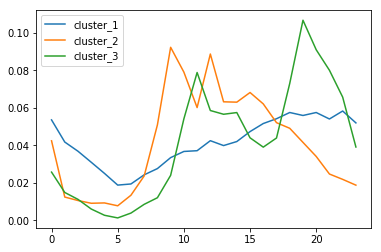

In [24]:
df.plot()

### b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

### Cluster_1: It decreases during the hour of 0 to five. Then it gradually gose up until the midnight.

### Cluster_2: It decreases during the hour of 0 to five. Then it dramatically goes up until 10. Then it goes up and down until 15. Finally it decreases until the midnight.

### Cluster_3: It decreases during the hour of 0 to five. Then it goes up until 11. Then it decreases again until 16. Then it dramatically goes up until 20. Finally it decrease until the midnight.

### c) Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)  

In [25]:
data3['label'] = res.labels_
data3.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77,label
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833,0
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407,0
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152,0
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000,0
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000,0


In [26]:
data3.loc[data3['label'] == 0]

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77,label
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833,0
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407,0
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152,0
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000,0
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000,0
5,ASSAULT: AGGRAVATED:KNIFE/CUTTING INSTR,P1V,0.154824,0.142857,0.137622,0.150337,0.134630,0.139117,0.140613,0.048616,...,0.018699,0.008227,0.032909,0.001496,0.008975,0.000748,0.002992,0.002244,0.009723,0
7,ASSAULT: SIMPLE,P2,0.133993,0.146027,0.150038,0.149014,0.146710,0.144064,0.130153,0.024068,...,0.030810,0.009900,0.032175,0.003670,0.011180,0.001622,0.008449,0.004865,0.008620,0
8,BATTERY: AGG PO HANDS NO/MIN INJURY,P2,0.153061,0.119048,0.127551,0.132653,0.151361,0.164966,0.151361,0.059524,...,0.034014,0.008503,0.028912,0.000000,0.008503,0.001701,0.008503,0.008503,0.008503,0
9,BATTERY: AGG: HANDS/FIST/FEET NO/MINOR INJURY,P2,0.114504,0.137405,0.190840,0.122137,0.137405,0.152672,0.145038,0.068702,...,0.053435,0.007634,0.030534,0.000000,0.015267,0.000000,0.022901,0.000000,0.022901,0
10,BATTERY: AGG: HANDS/FIST/FEET SERIOUS INJURY,P1V,0.202614,0.150327,0.065359,0.137255,0.104575,0.156863,0.183007,0.058824,...,0.032680,0.000000,0.039216,0.000000,0.013072,0.000000,0.006536,0.000000,0.000000,0


In [27]:
data3.loc[data3['label'] == 1]

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77,label
6,ASSAULT: PRO EMP HANDS NO/MIN INJURY,P2,0.030686,0.146209,0.185921,0.240072,0.180505,0.166065,0.050542,0.005415,...,0.032491,0.012635,0.023466,0.000000,0.010830,0.000000,0.005415,0.000000,0.007220,1
19,BATTERY: PRO EMP HANDS NO/MIN INJURY,P2,0.064915,0.151468,0.188563,0.165379,0.182380,0.185471,0.061824,0.009274,...,0.044822,0.013910,0.020093,0.000000,0.007728,0.000000,0.013910,0.006182,0.004637,1
24,BURGLARY: UNLAWFUL ENTRY,P1P,0.118287,0.157036,0.140041,0.139134,0.151824,0.156583,0.137095,0.039882,...,0.023340,0.011783,0.026286,0.005665,0.008611,0.003172,0.006345,0.000680,0.016542,1
36,DECEPTIVE PRACTICE: ATTEMPT - FINANCIAL IDENTI...,P2,0.064103,0.166667,0.163004,0.175824,0.179487,0.142857,0.108059,0.076923,...,0.009158,0.010989,0.018315,0.007326,0.010989,0.005495,0.007326,0.001832,0.023810,1
37,DECEPTIVE PRACTICE: BOGUS CHECK,P2,0.039088,0.188925,0.159609,0.185668,0.179153,0.166124,0.081433,0.055375,...,0.013029,0.013029,0.016287,0.019544,0.006515,0.006515,0.019544,0.000000,0.019544,1
38,DECEPTIVE PRACTICE: COUNTERFEIT CHECK,P2,0.031250,0.171875,0.197917,0.203125,0.164062,0.161458,0.070312,0.059896,...,0.002604,0.010417,0.033854,0.005208,0.007812,0.002604,0.018229,0.000000,0.015625,1
40,DECEPTIVE PRACTICE: CREDIT CARD FRAUD,P2,0.114954,0.125494,0.146574,0.142622,0.129117,0.172596,0.168643,0.067194,...,0.009552,0.003953,0.013505,0.002964,0.005929,0.001976,0.005270,0.008564,0.010870,1
41,DECEPTIVE PRACTICE: FINANCIAL IDENTITY THEFT $...,P2,0.084988,0.171565,0.163622,0.160445,0.152502,0.157268,0.109611,0.088959,...,0.013503,0.013503,0.024623,0.005560,0.019063,0.002383,0.015886,0.010326,0.011120,1
42,DECEPTIVE PRACTICE: FINANCIAL IDENTITY THEFT O...,P2,0.083665,0.168557,0.173460,0.149862,0.153846,0.153233,0.117377,0.088569,...,0.015017,0.014710,0.021146,0.006436,0.012872,0.005210,0.011033,0.003371,0.015323,1
43,DECEPTIVE PRACTICE: FORGERY,P2,0.040752,0.184953,0.163009,0.188088,0.163009,0.175549,0.084639,0.115987,...,0.025078,0.015674,0.031348,0.000000,0.015674,0.012539,0.018809,0.012539,0.012539,1


In [28]:
data3.loc[data3['label'] == 2]

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77,label
39,DECEPTIVE PRACTICE: COUNTERFEITING DOCUMENT,P2,0.136691,0.125899,0.131894,0.141487,0.134293,0.169065,0.160671,0.015588,...,0.023981,0.002398,0.019185,0.004796,0.008393,0.000000,0.014388,0.003597,0.007194,2
48,GAMBLING: GAME/DICE,P2,0.150000,0.138889,0.183333,0.100000,0.144444,0.177778,0.105556,0.016667,...,0.011111,0.000000,0.038889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
50,INTERFERENCE WITH PUBLIC OFFICER: OBSTRUCTING ...,P2,0.161710,0.167286,0.139405,0.115242,0.137546,0.139405,0.139405,0.029740,...,0.040892,0.009294,0.046468,0.000000,0.014870,0.001859,0.005576,0.001859,0.000000,2
57,NARCOTICS: MANU/DEL:CANNABIS 10GM OR LESS,P2,0.107438,0.168044,0.140496,0.143251,0.154270,0.173554,0.112948,0.008264,...,0.030303,0.000000,0.027548,0.000000,0.005510,0.000000,0.000000,0.000000,0.000000,2
58,NARCOTICS: MANU/DEL:CANNABIS OVER 10 GMS,P2,0.106618,0.150735,0.183824,0.161765,0.113971,0.187500,0.095588,0.022059,...,0.047794,0.003676,0.066176,0.003676,0.007353,0.000000,0.011029,0.000000,0.000000,2
59,NARCOTICS: MANU/DELIVER: HEROIN (WHITE),P2,0.133197,0.133197,0.176230,0.094262,0.145492,0.182377,0.135246,0.010246,...,0.020492,0.002049,0.018443,0.000000,0.002049,0.000000,0.002049,0.000000,0.000000,2
60,NARCOTICS: MANU/DELIVER:CRACK,P2,0.109489,0.167883,0.109489,0.145985,0.160584,0.197080,0.109489,0.000000,...,0.014599,0.000000,0.043796,0.000000,0.000000,0.000000,0.014599,0.000000,0.000000,2
62,NARCOTICS: POSS: CANNABIS 30GMS OR LESS,P2,0.126085,0.145738,0.156457,0.146503,0.152374,0.148545,0.124298,0.035733,...,0.027310,0.003828,0.029352,0.001531,0.016335,0.000766,0.006381,0.001021,0.005615,2
63,NARCOTICS: POSS: CANNABIS MORE THAN 30GMS,P2,0.097561,0.128049,0.143293,0.167683,0.167683,0.164634,0.131098,0.036585,...,0.033537,0.003049,0.054878,0.003049,0.021341,0.003049,0.015244,0.003049,0.006098,2
65,NARCOTICS: POSS: CRACK,P2,0.120347,0.131514,0.135236,0.156328,0.150124,0.151365,0.155087,0.029777,...,0.012407,0.001241,0.042184,0.000000,0.014888,0.000000,0.002481,0.000000,0.002481,2


### Most of criminal trespass, narcotics, other offense, robbery, theft are assigned to cluster_1.

### Most of battery are assigned to cluster_2.

### Most of deceptive practice are assigned to the cluster_3.

### d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)

In [29]:
cluster_1 = data3.loc[data3['label'] == 0]
cluster_2 = data3.loc[data3['label'] == 1]
cluster_3 = data3.loc[data3['label'] == 2]

In [30]:
week_1 = cluster_1.iloc[:,2:9]
#week_1.head()
week_2 = cluster_2.iloc[:,2:9]
week_3 = cluster_3.iloc[:,2:9]

In [63]:
week_1_mean = week_1.mean()
week_2_mean = week_2.mean()
week_3_mean = week_3.mean()

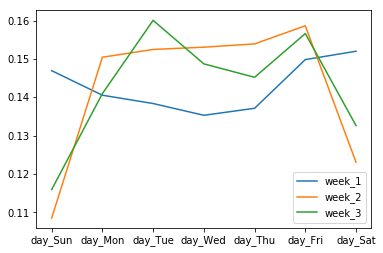

In [77]:
plt.plot(week_1_mean, label='week_1')
plt.plot(week_2_mean, label='week_2')
plt.plot(week_3_mean, label='week_3')
plt.legend()

### Cluster_2 and Cluster_3 are more in the same trend. Cluster_1 is more like the opposite of Cluster_2 and Cluster_3.

In [67]:
#weeks = data3.iloc[:,2:9]
#weeks.head()

In [68]:
#km = KMeans(random_state=234,n_clusters=3)
#res=km.fit(weeks)
#print('Cluster assignments:',res.labels_)
#print('\nCluster centers:\n',res.cluster_centers_)
#print('\nSum of squared errors:',res.inertia_)

In [69]:
#df = pd.DataFrame(res.cluster_centers_)
#df.head()

In [70]:
#df = df.T
#df.columns = ['cluster_1', 'cluster_2', 'cluster_3']
#df.head()

In [71]:
#df.plot()

### e) Do the three clusters affect different types of communities/neighborhoods? To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster. You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.). You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

In [34]:
cluster_1.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77,label
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833,0
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407,0
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152,0
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000,0
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000,0


In [149]:
data4

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330
3,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859
4,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280
5,6,Lake View,1169108.569,1922712.107,1.1,11.4,4.7,2.6,17.0,60058,8.573972,5671
6,7,Lincoln Park,1170461.597,1915088.662,0.8,12.3,5.1,3.6,21.5,71551,9.027778,3989
7,8,Near North Side,1175512.220,1906089.147,1.9,12.9,7.0,2.5,22.6,88669,17.077160,9847
8,9,Edison Park,1125542.283,1945199.392,1.1,3.3,6.5,7.4,35.3,40959,4.794521,283
9,10,Norwood Park,1128781.603,1937473.002,2.0,5.4,9.0,11.5,39.5,32875,5.748359,1223


In [142]:
cluster_1_community = cluster_1.iloc[:,33:110]
cluster_1_community.head()
cluster_1_crime = cluster_1_community.mean()
#cluster_1_crime.sort_values()
cluster_1_crime.head()

community_area_1    0.014190
community_area_2    0.012614
community_area_3    0.013718
community_area_4    0.007307
community_area_5    0.004148
dtype: float64

In [143]:
cluster_2_community = cluster_2.iloc[:,33:110]
cluster_2_community.head()
cluster_2_crime = cluster_2_community.mean()
#cluster_2_crime.sort_values()
cluster_2_crime.head()

community_area_1    0.014446
community_area_2    0.014380
community_area_3    0.016437
community_area_4    0.010941
community_area_5    0.007502
dtype: float64

In [144]:
cluster_3_community = cluster_3.iloc[:,33:110]
cluster_3_community.head()
cluster_3_crime = cluster_3_community.mean()
#cluster_3_crime.sort_values()
cluster_3_crime.head()

community_area_1    0.007818
community_area_2    0.005919
community_area_3    0.007367
community_area_4    0.002166
community_area_5    0.001113
dtype: float64

In [145]:
(cluster_1_crime / (cluster_1_crime + cluster_2_crime + cluster_3_crime)).sort_values()

community_area_26    0.205895
community_area_9     0.213270
community_area_25    0.224986
community_area_27    0.227806
community_area_74    0.244181
community_area_23    0.249141
community_area_47    0.255101
community_area_32    0.260839
community_area_10    0.278081
community_area_29    0.283317
community_area_8     0.290990
community_area_75    0.300025
community_area_33    0.304662
community_area_67    0.311236
community_area_72    0.315707
community_area_68    0.317323
community_area_5     0.325020
community_area_49    0.325891
community_area_56    0.329577
community_area_13    0.330269
community_area_12    0.330728
community_area_53    0.331457
community_area_41    0.331758
community_area_64    0.335246
community_area_28    0.335655
community_area_71    0.336299
community_area_44    0.339640
community_area_51    0.339875
community_area_77    0.341620
community_area_7     0.343542
                       ...   
community_area_20    0.389955
community_area_61    0.390684
community_

In [146]:
(cluster_2_crime / (cluster_1_crime + cluster_2_crime + cluster_3_crime)).sort_values()

community_area_26    0.113229
community_area_25    0.169005
community_area_54    0.178365
community_area_29    0.194716
community_area_23    0.198164
community_area_67    0.207551
community_area_68    0.217048
community_area_27    0.221595
community_area_53    0.259055
community_area_46    0.261609
community_area_49    0.264101
community_area_69    0.268662
community_area_71    0.278807
community_area_44    0.289857
community_area_51    0.293204
community_area_66    0.298897
community_area_30    0.300810
community_area_40    0.301486
community_area_45    0.306992
community_area_61    0.307363
community_area_34    0.308491
community_area_58    0.310613
community_area_43    0.311227
community_area_73    0.339369
community_area_63    0.341544
community_area_42    0.350149
community_area_20    0.358211
community_area_19    0.359811
community_area_37    0.360029
community_area_59    0.372357
                       ...   
community_area_21    0.453242
community_area_14    0.454098
community_

In [147]:
(cluster_3_crime / (cluster_1_crime + cluster_2_crime + cluster_3_crime)).sort_values()

community_area_76    0.043879
community_area_7     0.054250
community_area_11    0.055770
community_area_77    0.070564
community_area_55    0.073651
community_area_12    0.074784
community_area_41    0.080586
community_area_24    0.085019
community_area_74    0.085492
community_area_17    0.086285
community_area_5     0.087213
community_area_36    0.091569
community_area_10    0.100007
community_area_72    0.105222
community_area_4     0.106088
community_area_39    0.107296
community_area_65    0.107658
community_area_70    0.108079
community_area_64    0.109364
community_area_14    0.110105
community_area_32    0.115381
community_area_9     0.116150
community_area_6     0.117257
community_area_62    0.120985
community_area_59    0.125692
community_area_15    0.125904
community_area_57    0.128812
community_area_16    0.131284
community_area_21    0.144147
community_area_8     0.145455
                       ...   
community_area_56    0.244995
community_area_20    0.251834
community_

### After the calculation, most of the community areas with disproportionate amounts are having high percentage of households below poverty and high percentage of aged under 18 or over 60 and low per capita income.

### f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

In [182]:
print('The proportion of P1P in data is :\n', len(data3[data3.Category == 'P1P']) / 119)
print('The proportion of P1V in data is :\n', len(data3[data3.Category == 'P1V']) / 119)
print('The proportion of P2 in data is :\n', len(data3[data3.Category == 'P2']) / 119)

The proportion of P1P in data is :
 0.12605042016806722
The proportion of P1V in data is :
 0.20168067226890757
The proportion of P2 in data is :
 0.6722689075630253


In [189]:
print('The proportion of cluster_1 in data is :\n', len(cluster_1) / 119)
print('The proportion of cluster_2 in data is :\n', len(cluster_2) / 119)
print('The proportion of cluster_3 in data is :\n', len(cluster_3) / 119)

The proportion of cluster_1 in data is :
 0.5798319327731093
The proportion of cluster_2 in data is :
 0.226890756302521
The proportion of cluster_3 in data is :
 0.19327731092436976


### The proportion divided by FBI's division and the proportion divided by clustering are basically the same. So I think the three group formed pretty well. 

In [175]:
print('The number of P1P in cluster_1 is :\n',len(cluster_1[cluster_1.Category == 'P1P']))
print('The number of P1V in cluster_1 is :\n',len(cluster_1[cluster_1.Category == 'P1V']))
print('The number of P2 in cluster_1 is :\n',len(cluster_1[cluster_1.Category == 'P2']))

The number of P1P in cluster_1 is :
 11
The number of P1V in cluster_1 is :
 24
The number of P2 in cluster_1 is :
 34


In [176]:
print('The number of P1P in cluster_2 is :\n',len(cluster_2[cluster_2.Category == 'P1P']))
print('The number of P1V in cluster_2 is :\n',len(cluster_2[cluster_2.Category == 'P1V']))
print('The number of P2 in cluster_2 is :\n',len(cluster_2[cluster_2.Category == 'P2']))

The number of P1P in cluster_2 is :
 4
The number of P1V in cluster_2 is :
 0
The number of P2 in cluster_2 is :
 23


In [177]:
print('The number of P1P in cluster_3 is :\n',len(cluster_3[cluster_3.Category == 'P1P']))
print('The number of P1V in cluster_3 is :\n',len(cluster_3[cluster_3.Category == 'P1V']))
print('The number of P2 in cluster_3 is :\n',len(cluster_3[cluster_3.Category == 'P2']))

The number of P1P in cluster_3 is :
 0
The number of P1V in cluster_3 is :
 0
The number of P2 in cluster_3 is :
 23


### Cluster_2 and Cluster_3 mostly consist of P2 crime. Cluster_1 has all three types.

### g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)

In [86]:
weeks = data3.iloc[:,2:9]
weeks.head()

,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat
0,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972
1,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185
2,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776
3,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000
4,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275


In [96]:
# K-Means
range_n_clusters = range(2,10)


for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=234)
    cluster_labels=clusterer.fit_predict(weeks)    
    silhouette_avg = silhouette_score(weeks, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.23557859671599807
For n_clusters = 3, the average silhouette_score is : 0.2179643975075138
For n_clusters = 4, the average silhouette_score is : 0.22680479217770247
For n_clusters = 5, the average silhouette_score is : 0.23474667108179342
For n_clusters = 6, the average silhouette_score is : 0.1688585950429262
For n_clusters = 7, the average silhouette_score is : 0.16423545242687282
For n_clusters = 8, the average silhouette_score is : 0.16224844572551678
For n_clusters = 9, the average silhouette_score is : 0.1590214012017575


In [114]:
km = KMeans(random_state=234,n_clusters=2)
res=km.fit(hours)
print('Cluster assignments:',res.labels_)
print('\nCluster centers:\n',res.cluster_centers_)
print('\nSum of squared errors:',res.inertia_)

Cluster assignments: [1 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1
 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0
 1 0 0 0 1 1 1 0]

Cluster centers:
 [[0.03587041 0.01573539 0.01273276 0.01071396 0.01022833 0.00890864
  0.01356687 0.0239848  0.04008583 0.067193   0.06964923 0.06630146
  0.07625788 0.06028238 0.06056667 0.06112272 0.05667248 0.05416756
  0.05929003 0.05724305 0.04578828 0.0368252  0.0316543  0.02515875]
 [0.05337723 0.0410147  0.03627485 0.02944552 0.02263644 0.0161319
  0.01628793 0.01897523 0.02209455 0.02784887 0.03433094 0.03820714
  0.04053426 0.03929722 0.04152069 0.0440057  0.04773534 0.04995639
  0.0581818  0.06668189 0.06876757 0.06462987 0.06696588 0.05509806]]

Sum of squared errors: 1.1257498352328121


In [121]:
np.unique(res.labels_, return_counts=True)

(array([0, 1], dtype=int32), array([52, 67]))

### For the K-Means, there are 2 clusters. There are 67 elements in one cluster and 52 elements in another one. The Sum of squared errors is 1.1257498352328121.

In [100]:
# Gaussian mixture models
range_n_clusters = range(2,10)


for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters, random_state=234)
    cluster_labels=clusterer.fit_predict(weeks)    
    silhouette_avg = silhouette_score(weeks, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.25672726757004694
For n_clusters = 3, the average silhouette_score is : 0.27257976718174254
For n_clusters = 4, the average silhouette_score is : 0.17885441375662414
For n_clusters = 5, the average silhouette_score is : 0.07349467505813091
For n_clusters = 6, the average silhouette_score is : 0.06978694458057304
For n_clusters = 7, the average silhouette_score is : 0.11243081975954333
For n_clusters = 8, the average silhouette_score is : 0.12517896381164914
For n_clusters = 9, the average silhouette_score is : 0.10699103367665719


In [123]:
gmm = GaussianMixture(n_components=3,random_state=100)
res = gmm.fit(weeks)

print('Probabilities of belonging to cluster 1:\n',res.predict_proba(weeks)[:,1])
print('\nCluster centers:\n',res.means_)
print('\nCluster covariances:\n',res.covariances_)
print('\nLog-likelihood per sample:',res.score(weeks))


Probabilities of belonging to cluster 1:
 [8.55403919e-01 3.46223292e-01 5.35795372e-01 9.78348115e-01
 1.00070258e-03 8.89279525e-01 1.11267900e-14 9.69986583e-01
 9.80112312e-01 9.13388984e-01 1.91010793e-03 2.63330884e-02
 5.40182381e-03 6.00238112e-02 6.02075234e-06 3.73889013e-02
 8.26971569e-01 1.09917456e-01 4.80545702e-01 1.20448207e-05
 9.11693061e-01 9.66285017e-01 9.81584911e-01 2.67670853e-03
 9.85014117e-01 9.91750297e-01 1.09481814e-04 9.69269870e-01
 7.41739497e-01 9.11451920e-01 4.21722098e-26 5.91231211e-01
 9.91214814e-01 9.67461443e-01 9.94340504e-01 9.52711820e-01
 2.07782266e-01 4.05411622e-04 2.11265527e-07 9.21410027e-01
 8.98289327e-01 8.55207029e-01 8.30578864e-01 9.61368356e-05
 1.29261384e-02 4.33446659e-02 7.00567033e-01 1.44499163e-02
 9.80133020e-01 7.05589095e-01 9.56779378e-01 9.89875322e-01
 5.57495851e-40 2.97785152e-01 9.46270867e-01 8.94239598e-01
 9.74675023e-01 9.38569346e-01 5.38591951e-06 1.05448114e-01
 1.69424600e-02 2.59787328e-05 9.78546213e-

In [141]:
res.weights_ * 119

array([30.52088877, 70.55066243, 17.9284488 ])

### For the Gaussian mixture models, there are 3 clusters. There are 30 elements in the first cluster and 71 elements in  the second, and 18 elements in the third one.

In [125]:
# Bottom-up hierarchical clustering with "single link" distance metric
range_n_clusters = range(2,10)
Z_single = linkage(weeks, 'single')

for n_clusters in range_n_clusters:
    #clusterer = GaussianMixture(n_components=n_clusters, random_state=234)
    cluster_labels=fcluster(Z_single, n_clusters, criterion='maxclust')     
    silhouette_avg = silhouette_score(weeks, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.6377648080667613
For n_clusters = 3, the average silhouette_score is : 0.5568477382969328
For n_clusters = 4, the average silhouette_score is : 0.40557775075981567
For n_clusters = 5, the average silhouette_score is : 0.38770381887486705
For n_clusters = 6, the average silhouette_score is : 0.3900761951022192
For n_clusters = 7, the average silhouette_score is : 0.3462184482039438
For n_clusters = 8, the average silhouette_score is : 0.3289981576435591
For n_clusters = 9, the average silhouette_score is : 0.32542192748924165


In [126]:
fcluster(Z_single, 2, criterion='maxclust')

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [127]:
np.unique(fcluster(Z_single, 2, criterion='maxclust'), return_counts=True)

(array([1, 2], dtype=int32), array([118,   1]))

### For the Bottom-up hierarchical clustering with "single link" distance metric, there are 2 clusters. There are 118 elements in one cluster and 1 element in another one. 

In [128]:
# Bottom-up hierarchical clustering with "complete link" distance metric
range_n_clusters = range(2,10)
Z_complete = linkage(weeks, 'complete')

for n_clusters in range_n_clusters:
    #clusterer = GaussianMixture(n_components=n_clusters, random_state=234)
    cluster_labels=fcluster(Z_complete, n_clusters, criterion='maxclust')     
    silhouette_avg = silhouette_score(weeks, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.6100646113547021
For n_clusters = 3, the average silhouette_score is : 0.1726871814656612
For n_clusters = 4, the average silhouette_score is : 0.19215169374768618
For n_clusters = 5, the average silhouette_score is : 0.15025207822499775
For n_clusters = 6, the average silhouette_score is : 0.15229681572228093
For n_clusters = 7, the average silhouette_score is : 0.14926267616109448
For n_clusters = 8, the average silhouette_score is : 0.10130440123428043
For n_clusters = 9, the average silhouette_score is : 0.10066503899164776


In [129]:
fcluster(Z_complete, 2, criterion='maxclust')

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [130]:
np.unique(fcluster(Z_complete, 2, criterion='maxclust'), return_counts=True)

(array([1, 2], dtype=int32), array([  2, 117]))

### For the Bottom-up hierarchical clustering with "complete link" distance metric, there are 2 clusters. There are 2 elements in one cluster and 117 element in another one. 

### the Bottom-up hierarchical clustering with "single link" distance metric and the Bottom-up hierarchical clustering with "complete link" distance metric are very similar on the elements in each clusters. Only the Gaussian mixture models has three clusters. The rest of the model have 2 clusters.